# **Animal-detection-with-Modified-YOLOv5n (Nano)**

## **Drive mounting**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Downloading YOLOv5**

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 12975, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 12975 (delta 81), reused 100 (delta 60), pack-reused 12844
Receiving objects: 100% (12975/12975), 13.11 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (8916/8916), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 7.7 MB/s 


## **Downloading the Dataset from roboflow**



In [ ]:
!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 7.8 MB/s 
     |████████████████████████████████| 178 kB 63.3 MB/s 
     |████████████████████████████████| 1.1 MB 54.6 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 138 kB 68.0 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.15-py3-none-any.whl size=24936 sha256=eb541885856c9c77e19bf7cb4281aa4ff1c61019019c855c3e3da1a5e1e25e9a
  Stored in directory: /root/.cache/pip/wheels/13/e0/a3/fe183fffc3972cb9264e800763d4bbfff80d5309137c410217
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0dae5714c3f42f55dfb32ca6db67ed9afd1ea9308ffa790daf259a9e026fe8f1
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e

In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="q4FQkkxEYOVxClvXLjwm")
project = rf.workspace("interview").project("animal-classifier")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to animal-classifier-2 in yolov5pytorch:: 100%|██████████| 1122/1122 [00:00<00:00, 1868.67it/s]


### **Training**

In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data /content/yolov5/animal-classifier-2/data.yaml --weights yolov5n.pt

train: weights=yolov5n.pt, cfg=, data=/content/yolov5/animal-classifier-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-180-g82bec4c Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, 

### **Inference**

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-10-3 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 10639080 parameters, 0 gradients
Adding AutoShape... 


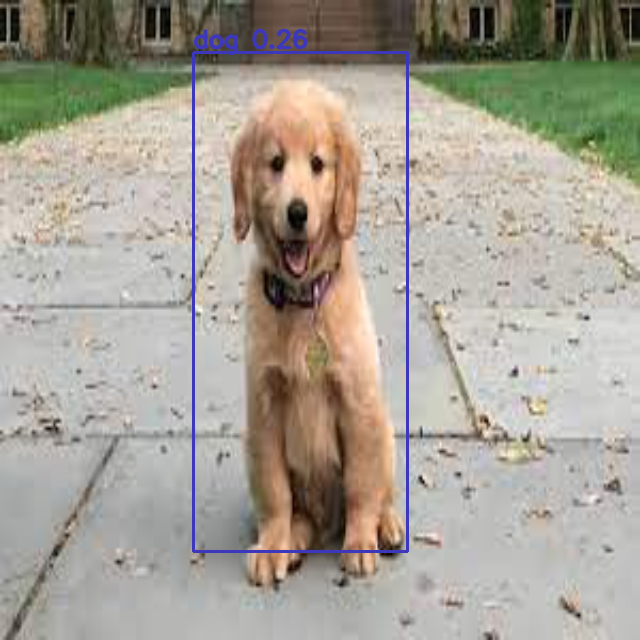

In [16]:
import torch    
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []
    confidences = []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
        confidence = np.round(confidence,2)
        confidences.append(confidence)
    return boxes, colors, names, confidences


def draw_detections(boxes, colors, names, confidences, img):
    for box, color, name, confidence in zip(boxes, colors, names, confidences):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name+' '+str(confidence), (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_path = "/content/drive/MyDrive/notebooks/images/test-dog.jpg"
img = np.array(Image.open(image_path))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()

model = torch.hub.load('ultralytics/yolov5', 'custom', '/content/drive/MyDrive/notebooks/weights/modified-nano/best.pt')
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]


results = model([rgb_img])
boxes, colors, names, confidences = parse_detections(results)
detections = draw_detections(boxes, colors, names, confidences, rgb_img.copy())
Image.fromarray(detections)

### **Class Activation Map (CAM)**



In [4]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.5-py3-none-any.whl size=37027 sha256=c247a87a7f2821fa57ba9b38939d35c7caf972d9909c690ef19eacd91afb8736
  Stored in directory: /root/.cache/pip/wheels/f7/c1/fd/59384047f1fab2f99d96b224bdfd0d2b198f896bdb107d66fd
Successfully built grad-cam


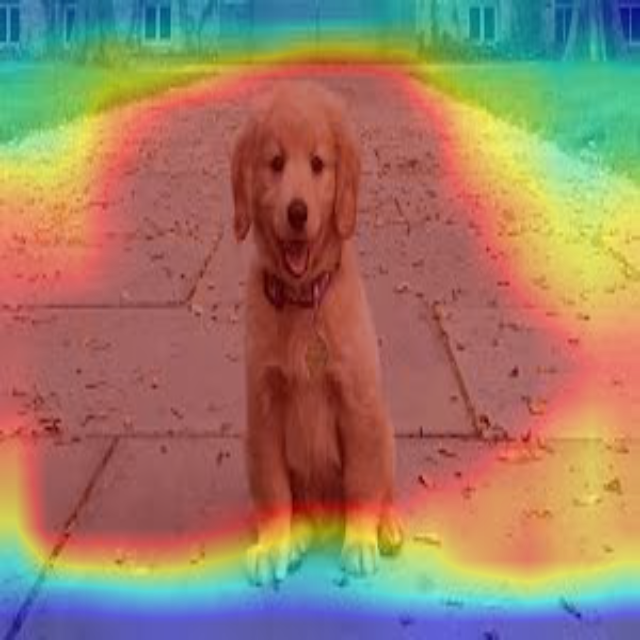

In [17]:
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image

img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=False)
Image.fromarray(cam_image)